# Running membership inference attacks on the Nursery data

In this tutorial we will show how to run black-box membership attacks. This will be demonstrated on the Nursery dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/nursery).

In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 28.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


We have already preprocessed the dataset such that all categorical features are one-hot encoded, and the data was scaled using sklearn's StandardScaler.

In [ ]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Load data

In [ ]:
from art.utils import load_nursery
(x_train, y_train), (x_test, y_test), _, _ = load_nursery(test_set=0.5)

## Train random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier() # Define random forest model using RandomForestClassifier
model.fit(x_train, y_train) # Evalutation
print('Base model accuracy: ', model.score(x_test, y_test ))

Base model accuracy:  0.9745291756715035


## Attack
### Rule-based attack
The rule-based attack uses the simple rule to determine membership in the training data: if the model's prediction for a sample is correct, then it is a member. Otherwise, it is not a member.

In [ ]:
import numpy as np
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

art_classifier = ScikitlearnRandomForestClassifier(model) # use ScikitlearnRandomForestClassifier in art
attack = MembershipInferenceBlackBoxRuleBased(art_classifier) # define the attack object using MembershipInferenceBlackBoxRuleBased

# infer attacked feature
inferred_train = attack.infer(x_train, y_train)
inferred_test = attack.infer(x_test, y_test)

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


Members Accuracy: 1.0000
Non Members Accuracy 0.0255
Attack Accuracy 0.5127


This means that on average for 51% of the data, membership status is inferred correctly.

In [ ]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

# rule-based
print(calc_precision_recall(np.concatenate((inferred_train, inferred_test)),
                            np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test)))))) # using the infer attacked features to calculate the precision and recall of the membership attack

(0.506449847549058, 1.0)


### Black-box attack
The black-box attack basically trains an additional classifier (called the attack model) to predict the membership status of a sample. It can use as input to the learning process probabilities/logits or losses, depending on the type of model and provided configuration.
#### Train attack model

In [ ]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack_train_ratio = 0.5
attack_test_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_test_ratio)

# Define the black-box membership inference attack
bb_attack = MembershipInferenceBlackBox(art_classifier) # using MembershipInferenceBlackBox function

# train attack model
bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
              x_test[:attack_test_size], y_test[:attack_test_size])

#### Infer membership and check accuracy

In [ ]:
# get inferred values
inferred_train_bb = bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])

# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(f"Members Accuracy: {train_acc:.4f}")
print(f"Non Members Accuracy {test_acc:.4f}")
print(f"Attack Accuracy {acc:.4f}")

Members Accuracy: 0.7181
Non Members Accuracy 0.6064
Attack Accuracy 0.6622


Achieves much better results than the rule-based attack.

In [ ]:
# black-box
print(calc_precision_recall(np.concatenate((inferred_train_bb, inferred_test_bb)),
                            np.concatenate((np.ones(len(inferred_train_bb)), np.zeros(len(inferred_test_bb))))))

(0.645931685642877, 0.718122877431306)


## Train neural network model

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from art.estimators.classification.pytorch import PyTorchClassifier

# reduce size of training set to make attack slightly better
train_set_size = 500
x_train = x_train[:train_set_size]
y_train = y_train[:train_set_size]
x_test = x_test[:train_set_size]
y_test = y_test[:train_set_size]
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)


class NurseryDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = torch.from_numpy(x.astype(np.float64)).type(torch.FloatTensor)

        if y is not None:
            self.y = torch.from_numpy(y.astype(np.int8)).type(torch.LongTensor)
        else:
            self.y = torch.zeros(x.shape[0])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if idx >= len(self.x):
            raise IndexError("Invalid Index")

        return self.x[idx], self.y[idx]

train_set = NurseryDataset(x_train, y_train)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=0)

device = torch.device("cpu")

In [ ]:
# Define the neural network model
class ModelToAttack(nn.Module):

    def __init__(self, num_classes, num_features):
        super(ModelToAttack, self).__init__()

        self.fc1 = nn.Sequential(
                nn.Linear(num_features, 1024),
                nn.Tanh(), )

        self.fc2 = nn.Sequential(
                nn.Linear(1024, 512),
                nn.Tanh(), )

        self.fc3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.Tanh(), )

        self.fc4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return self.classifier(out)

In [ ]:
# train the nn model
mlp_model = ModelToAttack(4, 24)
mlp_model = torch.nn.DataParallel(mlp_model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

for epoch in range(20):
    for (input, targets) in train_loader:
        input, targets = torch.autograd.Variable(input), torch.autograd.Variable(targets)

        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(input)
        outputs = outputs.to(device)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()


mlp_art_model = PyTorchClassifier(model=mlp_model, loss=criterion, optimizer=optimizer, input_shape=(24,), nb_classes=4)

train_pred = np.array([np.argmax(arr) for arr in mlp_art_model.predict(x_train.astype(np.float32))])
print('Base model Train accuracy: ', np.sum(train_pred == y_train) / len(y_train))

test_pred = np.array([np.argmax(arr) for arr in mlp_art_model.predict(x_test.astype(np.float32))])
print('Base model Test accuracy: ', np.sum(test_pred == y_test) / len(y_test))

Base model Train accuracy:  0.998
Base model Test accuracy:  0.932


### Rule-based attack

In [ ]:
mlp_attack = MembershipInferenceBlackBoxRuleBased(mlp_art_model)

# infer
mlp_inferred_train = mlp_attack.infer(x_train.astype(np.float32), y_train)
mlp_inferred_test = mlp_attack.infer(x_test.astype(np.float32), y_test)

# check accuracy
mlp_train_acc = np.sum(mlp_inferred_train) / len(mlp_inferred_train)
mlp_test_acc = 1 - (np.sum(mlp_inferred_test) / len(mlp_inferred_test))
mlp_acc = (mlp_train_acc * len(mlp_inferred_train) + mlp_test_acc * len(mlp_inferred_test)) / (len(mlp_inferred_train) + len(mlp_inferred_test))
print(mlp_train_acc)
print(mlp_test_acc)
print(mlp_acc)

print(calc_precision_recall(np.concatenate((mlp_inferred_train, mlp_inferred_test)),
                            np.concatenate((np.ones(len(mlp_inferred_train)), np.zeros(len(mlp_inferred_test))))))

0.998
0.06799999999999995
0.533
(0.5170984455958549, 0.998)


### Black-box attack

In [ ]:
mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')

# train attack model
mlp_attack_bb.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size],
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size])

# infer
mlp_inferred_train_bb = mlp_attack_bb.infer(x_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
mlp_inferred_test_bb = mlp_attack_bb.infer(x_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

# check accuracy
mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
print(f"Attack Accuracy {mlp_acc_bb:.4f}")

print(calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                            np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb))))))

Members Accuracy: 0.5440
Non Members Accuracy 0.5160
Attack Accuracy 0.5300
(0.5291828793774319, 0.544)


In [ ]:
from sklearn.metrics import classification_report

y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
print(classification_report(y_pred=y_train_pred, y_true=y_train_true))

              precision    recall  f1-score   support

         0.0       0.53      0.52      0.52       250
         1.0       0.53      0.54      0.54       250

    accuracy                           0.53       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.53      0.53      0.53       500



For the pytorch target model we were able to achieve slightly better than random attack performance, but not as good as for the random forest model.

### Worst Case vs Average Case evaluation for Black-Box Attack

In [ ]:
from art.metrics.privacy.worst_case_mia_score import get_roc_for_fpr

# we run the worst case metric on trainset to find an appropriate threshold
# Black Box
bb_members_test_prob = mlp_attack_bb.infer(x_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:], probabilities=True)
bb_nonmembers_test_prob = mlp_attack_bb.infer(x_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:], probabilities=True)

bb_mia_test_probs = np.concatenate((np.squeeze(bb_members_test_prob, axis=-1),
                               np.squeeze(bb_nonmembers_test_prob, axis=-1)))

bb_mia_test_labels = np.concatenate((np.ones_like(y_train[:attack_train_size]), np.zeros_like(y_test[:attack_test_size])))
# We allow 1% FPR
fpr, tpr, threshold = get_roc_for_fpr(attack_proba=bb_mia_test_probs, attack_true=bb_mia_test_labels, targeted_fpr=0.01)[0]
print(f'{tpr=}: {fpr=}: {threshold=}')

tpr=0.008: fpr=0.004: threshold=0.99


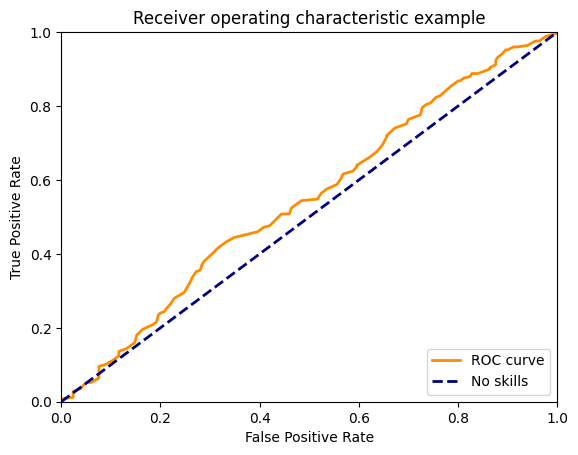

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_score=bb_mia_test_probs, y_true=bb_mia_test_labels)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", linewidth =2, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linewidth =2, linestyle="--", label='No skills')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### Worst Case per Class evaluation for Black-Box Attack

In [ ]:
# We allow 1% FPR
target_labels = np.concatenate((y_train[attack_train_size:], y_test[attack_test_size:]))
results = get_roc_for_fpr(attack_proba=bb_mia_test_probs, attack_true=bb_mia_test_labels, targeted_fpr=0.01, target_model_labels=target_labels)
for v, fpr, tpr, threshold in results:
    print(f'Class {v}: {tpr=:.4f}: {fpr=:.4f}: {threshold=:.4f}')

Class 0: tpr=0.0000: fpr=0.0000: threshold=1.9800
Class 1: tpr=0.1667: fpr=0.0000: threshold=0.9900
Class 2: tpr=0.0109: fpr=0.0000: threshold=0.9600
Class 3: tpr=0.0000: fpr=0.0000: threshold=1.9900
